We are continuing the Income Prediction task.  We will restore the model created, tweek some of the parameters, and continue training.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow import feature_column
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import confusion_matrix

In [2]:
tf.keras.backend.clear_session()

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def plotConfusion(test_labels, predictions_baseline, p):
    cm = confusion_matrix(test_labels, predictions_baseline > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(0.5))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    truePositives = cm[1][1]
    trueNegatives = cm[0][0]
    falsePositives = cm[0][1]
    falseNegatives = cm[1][0]
    
    precision = truePositives / (truePositives + falsePositives)
    recall = truePositives / (truePositives + falseNegatives)
    f1ScoreCalculated =  2 * (precision * recall) / (precision + recall)
    
    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1 Score Calculated: {:.4f}'.format(f1ScoreCalculated))

In [5]:
df=pd.read_csv("adult.csv")

In [6]:
df = df.drop(columns=['fnlwgt'])
df['income'] = np.where(df['income']=="<=50K", 0, 1)

In [7]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

20838 train examples
5210 validation examples
6513 test examples


In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('income')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [9]:
feature_columns = []

In [10]:
for header in ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']:
  feature_columns.append(feature_column.numeric_column(header))

In [11]:
indicator_column_names = ['workclass', 'education', 'marital.status', 'occupation', 'race',
                          'relationship', 'sex', 'native.country']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, df[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

In [12]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [13]:
batch_size = 32
train_ds = df_to_dataset(df, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

We restore the model, including its weights and the optimizer

In [14]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')
]

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1, activation='sigmoid')
])

Now load the weights of the model, saved previously.

In [15]:
model.load_weights('./checkpoints/my_checkpoint')

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

And try running our model with our test data.

In [17]:
predictions = model.predict(test_ds)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


Legitimate Transactions Detected (True Negatives):  4757
Legitimate Transactions Incorrectly Detected (False Positives):  177
Fraudulent Transactions Missed (False Negatives):  759
Fraudulent Transactions Detected (True Positives):  820
Total Fraudulent Transactions:  1579
Precision: 0.8225
Recall: 0.5193
F1 Score Calculated: 0.6366


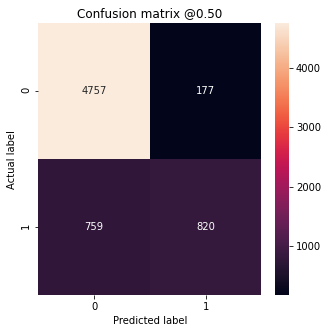

In [18]:
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
plotConfusion(test_labels, predictions, 0.5)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  13824     
_________________________________________________________________
dense_1 (Dense)              multiple                  16512     
_________________________________________________________________
dense_2 (Dense)              multiple                  8256      
_________________________________________________________________
dense_3 (Dense)              multiple                  4160      
_________________________________________________________________
dense_4 (Dense)              multiple                  2080      
_________________________________________________________________
dense_5 (Dense)              multiple                  1

We are back to where we were before.  We will now fine tune the model.  We think that the mopdel would perform a little better if we add a new layer

In [20]:
model.pop()

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  13824     
_________________________________________________________________
dense_1 (Dense)              multiple                  16512     
_________________________________________________________________
dense_2 (Dense)              multiple                  8256      
_________________________________________________________________
dense_3 (Dense)              multiple                  4160      
_________________________________________________________________
dense_4 (Dense)              multiple                  2080      
_________________________________________________________________
dense_5 (Dense)              multiple                  1

In [22]:
model.add(layers.Dense(16, activation='relu'))

In [23]:
model.add(layers.Dense(16, activation='relu'))

In [24]:
model.add(layers.Dense(1, activation='sigmoid'))

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)
result = model.fit(train_ds,
          validation_data=val_ds,
          epochs=20)
model.summary()

Epoch 1/20
Consider rewriting this model with the Functional API.


C:\Users\Ivan Krsul\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


Consider rewriting this model with the Functional API.
1016/1018 [============================>.] - ETA: 0s - loss: 0.3127 - tp: 5036.0000 - fp: 1874.0000 - tn: 22810.0000 - fn: 2792.0000 - accuracy: 0.8565 - precision: 0.7288 - recall: 0.6433WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'workclass': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=string>, 'education': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'education.num': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=int64>, 'marital.status': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'occupation': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'relationship': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=string>, 'race': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=string>, 'sex': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) d

Epoch 17/20
1018/1018 [==============================] - 3s 3ms/step - loss: 0.2854 - tp: 5158.0000 - fp: 1690.0000 - tn: 23030.0000 - fn: 2683.0000 - accuracy: 0.8657 - precision: 0.7532 - recall: 0.6578 - val_loss: 0.2811 - val_tp: 893.0000 - val_fp: 325.0000 - val_tn: 3611.0000 - val_fn: 381.0000 - val_accuracy: 0.8645 - val_precision: 0.7332 - val_recall: 0.7009
Epoch 18/20
1018/1018 [==============================] - 3s 3ms/step - loss: 0.2965 - tp: 5120.0000 - fp: 1666.0000 - tn: 23054.0000 - fn: 2721.0000 - accuracy: 0.8653 - precision: 0.7545 - recall: 0.6530 - val_loss: 0.2745 - val_tp: 848.0000 - val_fp: 234.0000 - val_tn: 3702.0000 - val_fn: 426.0000 - val_accuracy: 0.8733 - val_precision: 0.7837 - val_recall: 0.6656
Epoch 19/20
1018/1018 [==============================] - 3s 3ms/step - loss: 0.2855 - tp: 5127.0000 - fp: 1674.0000 - tn: 23046.0000 - fn: 2714.0000 - accuracy: 0.8652 - precision: 0.7539 - recall: 0.6539 - val_loss: 0.2738 - val_tp: 836.0000 - val_fp: 225.0000 

Consider rewriting this model with the Functional API.
Legitimate Transactions Detected (True Negatives):  4586
Legitimate Transactions Incorrectly Detected (False Positives):  348
Fraudulent Transactions Missed (False Negatives):  522
Fraudulent Transactions Detected (True Positives):  1057
Total Fraudulent Transactions:  1579
Precision: 0.7523
Recall: 0.6694
F1 Score Calculated: 0.7084


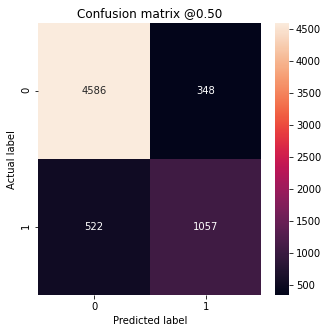

In [26]:
predictions = model.predict(test_ds)
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
plotConfusion(test_labels, predictions, 0.5)